# Análise da Rentabilidade de Fundos

### Inicializações

In [4]:
import pandas as pd
from datetime import datetime, date, timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import yfinance as yf

import utils


In [5]:
df_portofolio, df_quotes, _, df_historico = utils.load_data()
df_quotes = df_quotes.bfill()

AttributeError: module 'utils' has no attribute 'load_data'

In [ ]:
df_etf_quotes = pd.read_csv("etf_quotes.csv", parse_dates=True,index_col=0).sort_index(ascending=True).ffill()
"MEUD.PA" in df_etf_quotes.columns

True

In [ ]:
df_transacoes_portofolio = pd.read_csv('transacoes.csv' ,parse_dates=True)
df_transacoes_portofolio = df_transacoes_portofolio[pd.isnull(df_transacoes_portofolio['Data de resgate'])]

df_trans_etf = pd.read_csv('transacoes_etf.csv' ,parse_dates=True)
df_trans_etf = df_trans_etf[pd.isnull(df_trans_etf['Data de resgate'])]

df_transacoes_portofolio = pd.concat([df_transacoes_portofolio,df_trans_etf]).set_index('Code').drop('LU0122613903').drop(columns=['Data de resgate','Cotacao de resgate'])
df_transacoes_portofolio['Data de subscricao'] = df_transacoes_portofolio['Data de subscricao'].apply(lambda d: datetime.strptime(d, '%d-%m-%Y').date())


df_transacoes_portofolio['Data da cotacao'] = df_quotes.index[0]
df_transacoes_portofolio['Cotacao actual'] = df_transacoes_portofolio.apply(lambda x: df_quotes[x.name].iloc[0], axis=1)
df_transacoes_portofolio['Dias'] = (df_transacoes_portofolio['Data da cotacao']-df_transacoes_portofolio['Data de subscricao']).apply(lambda x: x.days)

df_transacoes_portofolio['Cotacao de Subscricao'] = df_transacoes_portofolio['Cotacao de Subscricao'].astype(float)

df_transacoes_portofolio.tail(5)

,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data da cotacao,Cotacao actual,Dias
Code,,,,,,,,
QTUM,Defiance Quantum,290.0,2025-01-29,78.618621,USD,2025-03-27,72.519411,57
MEUD.PA,Amundi Stoxx Europe 600,90.0,2025-01-30,253.240000,EUR,2025-03-27,256.589996,56
SC0U.DE,Invesco STOXX Europe 600 Banks,140.0,2025-03-05,145.738000,EUR,2025-03-27,148.119995,22
SIVR,abrdn Physical Silver,1000.0,2025-03-12,28.983850,USD,2025-03-27,29.813843,15
YINN,Direxion Daily FTSE China Bull 3X,350.0,2025-03-17,44.773543,USD,2025-03-27,40.108603,10


In [ ]:
df_historico['Cotacao de Subscricao'][df_historico['Cotacao de Subscricao'].apply(lambda x: isinstance(x, str))]

Series([], Name: Cotacao de Subscricao, dtype: float64)

### Cálculo Rentabilidade do Histórico

In [ ]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)
df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100

df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']


print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.5149396986434738
Ganho Absoluto 64251.66380990827 em 4241202.726910646
Rentabilidade Média Anual 8.538480812693262


### Cálculo Rentabilidade do Portfólio

In [ ]:
df_transacoes_portofolio['Rentabilidade anual %'] = df_transacoes_portofolio.apply(lambda x: 100*(math.pow(x['Cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_transacoes_portofolio['Rentabilidade Absoluta'] = df_transacoes_portofolio['Cotacao actual']*100/df_transacoes_portofolio['Cotacao de Subscricao']-100
df_transacoes_portofolio['Valor Actual'] = df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao actual']
print("Rentabilidade Absoluta", sum(df_transacoes_portofolio['Valor Actual'])*100/sum(df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao'])-100)

df_transacoes_portofolio['Ganho Absoluto'] = df_transacoes_portofolio['Quantidade']*(df_transacoes_portofolio['Cotacao actual']-df_transacoes_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_transacoes_portofolio['Ganho Absoluto']),'em', sum(df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']),'=', sum(df_transacoes_portofolio['Valor Actual']))

dias_medio = (df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']*df_transacoes_portofolio['Dias']).sum() / (df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_transacoes_portofolio['Ganho Absoluto'].sum()/sum(df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta 1.5554147512584393
Ganho Absoluto 6470.431429799615 em 415993.96074678143 = 422464.3921765811
Rentabilidade Média Anual 8.604142092131273


### Rentabilidade Global

In [ ]:

dias_medio = (df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']*df_transacoes_portofolio['Dias']).sum() 
dias_medio += (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum()
dias_medio_div = (df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']).sum() + (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
dias_medio = dias_medio / dias_medio_div
ganho = df_transacoes_portofolio['Ganho Absoluto'].sum() + df_historico['Ganho Absoluto'].sum()
ganho_relativo = ganho / (sum(df_transacoes_portofolio['Quantidade']*df_transacoes_portofolio['Cotacao de Subscricao']) + sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))
print("Rentabilidade Média Anual", 100*(math.pow(ganho_relativo+1, float(365.0/dias_medio))-1))


Rentabilidade Média Anual 8.54444930137397


In [ ]:
cols = ["Code","Nome",'Quantidade','Valor Actual','Ganho Absoluto','Rentabilidade anual %']
df_transacoes_portofolio.reset_index()[cols].groupby(by=["Code","Nome"]).sum().sort_values(by='Valor Actual', ascending=False)

,,Quantidade,Valor Actual,Ganho Absoluto,Rentabilidade anual %
Code,Nome,,,,
LU1965927921,DWS Invest ESG Floating Rate,1321.0000,142958.620000,1399.700000,18.358700
QTUM,Defiance Quantum,500.0000,36259.705254,2036.385254,18.717347
SIVR,abrdn Physical Silver,1000.0000,29813.843164,829.993164,98.779976
LU0524465977,Alken European Opport A,76.8238,27077.316548,2077.315552,254.917929
LU0173778175,Nordea Swedish Short Term Bond,1542.6480,25284.000720,284.001497,295.250286
LU0140363267,Franklin Mutual European Fund,889.0470,25168.920570,168.918930,6.681988
MEUD.PA,Amundi Stoxx Europe 600,90.0000,23093.099670,301.499670,8.943198
SGLD.AS,Invesco Physical Gold ETC,85.0000,23049.451141,2456.651141,60.451857
SC0U.DE,Invesco STOXX Europe 600 Banks,140.0000,20736.799316,333.479316,30.862334


In [ ]:
df_transacoes_portofolio['Valor Actual'].sum()

422464.39217658114

<Axes: title={'center': ' 6.09%'}>

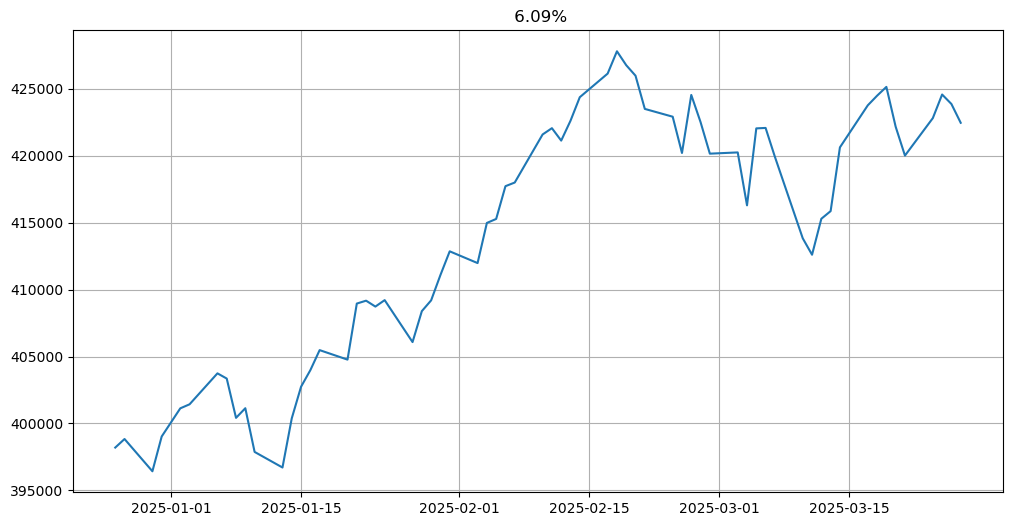

In [ ]:

horizon=65

df_global = df_quotes[df_portofolio.index][:horizon].apply(lambda x: sum(df_portofolio['Quantidade'][k]*v for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(12,6),grid=True,title = f"{df_global.iloc[0]/df_global.iloc[-1]-1: .2%}")

# SP 500 and MSCI Global Comparision

In [ ]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500.index = ds_sp500.index.date
ds_sp500.name = "SP500"
'''
tickers = ['MSCI']
start_date = '2021-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ds_msci = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
ds_msci.name = 'MSCI'
ds_msci = ds_msci.reindex(pd.date_range(ds_msci.index.min(),ds_msci.index.max())).interpolate()
ds_msci.index = ds_msci.index.date
ds_msci
'''

"\ntickers = ['MSCI']\nstart_date = '2021-01-01'\nend_date = datetime.today().strftime('%Y-%m-%d')\nds_msci = yf.download(tickers, start=start_date, end=end_date)['Adj Close']\nds_msci.name = 'MSCI'\nds_msci = ds_msci.reindex(pd.date_range(ds_msci.index.min(),ds_msci.index.max())).interpolate()\nds_msci.index = ds_msci.index.date\nds_msci\n"

In [ ]:
df_h = df_historico[(df_historico['Data de subscricao']<=ds_sp500.index.max()) & (df_historico['Data de resgate']<=ds_sp500.index.max()) ]
df_sp500_hist = df_h[['Dias']].copy()
df_sp500_hist['Cost'] = df_h.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
#df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[np.datetime64(x['Data de subscricao'])],axis=1)
df_sp500_hist['Quantidade'] = df_h.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[x['Data de subscricao']],axis=1)

df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_h.apply(lambda x: (ds_sp500[x['Data de resgate']]-ds_sp500[x['Data de subscricao']]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


SP500 Histórico: Custo=4241202.726910654, Ganho=129624.05894074574
Rentabilidade SP500 Histórico 17.827663486483793


In [ ]:
#Rentabilidade das transacçoes realizadas

def p_value_on_date(df_t, d):
    # amount in the end of the day
    df = df_t[(df_t['Data de subscricao']<=d) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>d))]
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] , axis=1).sum()

def b_value_on_date(df_t, d):
    # amount bought on d
    df = df_t[df_t['Data de subscricao']==d]
    if len(df)==0:
        return 0
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] , axis=1).sum()

def s_value_on_date(df_t, d):
    # amount sold on d
    df = df_t[df_t['Data de resgate']==d]
    if len(df)==0:
        return 0
    return df.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][d] , axis=1).sum()

def profitablity_graph(first_date, figsize=(12,6)):

    # Transactions
    df_transacoes = pd.concat([df_historico,df_transacoes_portofolio.reset_index()])
    df_t = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)].copy()
    df_t = df_t[(pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=first_date)]

    # df_t contain a copye of the transactions for which quotes exists (df_quotes)
    first_date = max(first_date,df_t['Data de subscricao'].min())
    last_date = df_quotes.index.max()
    
    # Portofolio dataframe
    p_data = pd.DataFrame(data={'date':df_quotes.sort_index()[first_date:last_date].index}) # Init with date ranges
    p_data.index = [x for x in p_data['date']]
    p_data['p_value'] = p_data.apply(lambda x: p_value_on_date(df_t,x['date']),axis=1)
    p_data['b_value'] = p_data.apply(lambda x: b_value_on_date(df_t,x['date']),axis=1)
    p_data['s_value'] = p_data.apply(lambda x: s_value_on_date(df_t,x['date']),axis=1)
    p_data['pnd_value'] = p_data['p_value'] - p_data['b_value'] + p_data['s_value']
    p_data['daily_growth'] = (p_data['pnd_value'].shift(-1)/p_data['p_value']).shift(1,fill_value=1)
    p_data['Portofolio'] = p_data['daily_growth'].cumprod()
    print(p_data['Portofolio'].tail())

    profit_period = p_data['Portofolio'].iloc[-1]-1
    profit_year = p_data['Portofolio'].iloc[-1]**(365/(last_date - first_date).days)-1
    title = f"Profitability: { profit_period: .2%} / period; {profit_year:.2%} / year"
    sp500_data = (ds_sp500[first_date:].ffill().pct_change().fillna(0)+1).cumprod()
    #msci_data = (ds_msci[first_date:].ffill().pct_change().fillna(0)+1).cumprod()
    #pd.concat([sp500_data, msci_data, p_data['Portofolio']],axis=1).plot(title=title,figsize=figsize,grid=True)
    pd.concat([sp500_data, p_data['Portofolio']],axis=1).plot(title=title,figsize=figsize,grid=True)


2025-03-21    0.978462
2025-03-24    0.986652
2025-03-25    0.991062
2025-03-26    0.989411
2025-03-27    0.986131
Name: Portofolio, dtype: float64


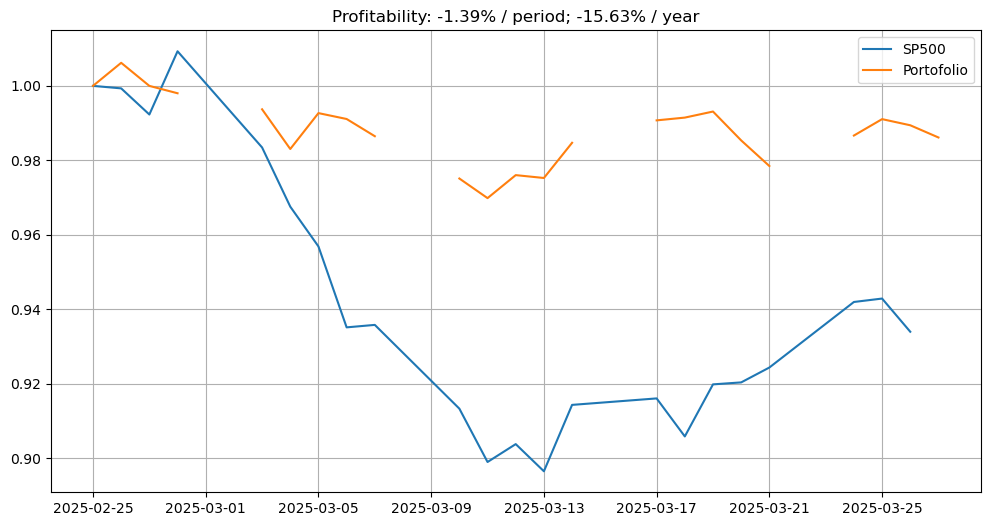

In [ ]:
profitablity_graph(date.today()-timedelta(days=30))

2025-03-21    1.073932
2025-03-24    1.082922
2025-03-25    1.087762
2025-03-26    1.085950
2025-03-27    1.082350
Name: Portofolio, dtype: float64


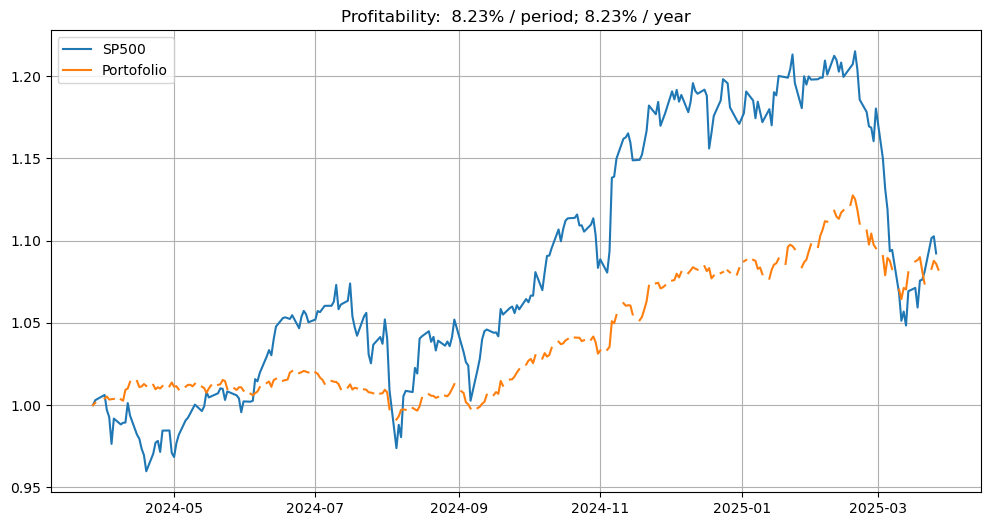

In [ ]:
profitablity_graph((datetime.now() - timedelta(days=365)).date())

2025-03-27


<Axes: >

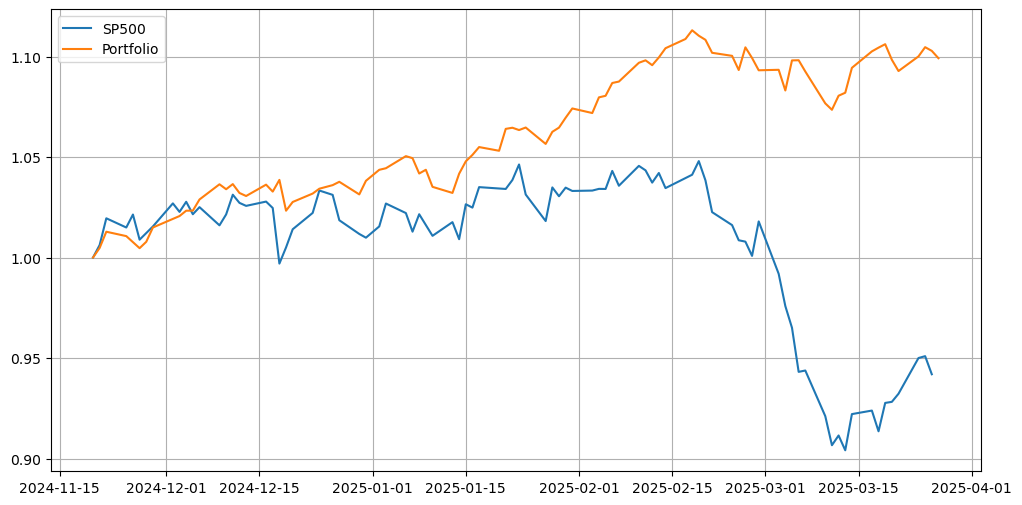

In [ ]:
#Comparision of the current portfolio
n_days = 90
ds = df_quotes[df_portofolio.index][:n_days].apply(lambda x: sum(df_portofolio['Quantidade'][k]*v for k,v in x.items()),axis=1).sort_index()
#ds.index = [pd.Timestamp(x) for x in ds.index]
ds = ds.reindex(pd.date_range(ds.index.min(),ds.index.max())).interpolate()
ds.index = ds.index.date
ds.name = "Portfolio"
print(ds.index[-1])
pd.concat([(ds_sp500[ds.index.min():].ffill().pct_change().fillna(0)+1).cumprod(), (ds.ffill().pct_change().fillna(0)+1).cumprod()],axis=1).plot(figsize=(12,6),grid=True)